In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False

    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [12]:

class Particle:
    swarm_best_coloring = None
    swarm_best_value = None
    best_iter = 0
    
    def __init__(self, graph, num_colors, c_i, c_p, c_s):
        self.c_i = c_i
        self.c_p = c_p
        self.c_s = c_s
        
        self.graph = graph
        self.num_colors = num_colors
        self.colors = np.random.randint(0, num_colors, len(graph.edges()))
        self.velocity = np.random.uniform(-1, 1, len(graph.edges()))
        
        self.personal_best_coloring = self.colors.copy()
        self.value = self.calculate_conflicts()
        self.personal_best_value = self.value
        self.personal_least_colors = self.num_colors
        if Particle.swarm_best_value is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_coloring = self.colors.copy()
            Particle.best_iter = 0
            
    def calculate_conflicts(self):
        edge_color = {edge: self.colors[i] for i, edge in enumerate(self.graph.edges())}
        num = 0
    
        for edge in self.graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(self.graph, u)
            v_edges = neighbor_edges_of_node(self.graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1
        
        return len(self.graph.edges()) - num
    
    def update_colors(self, iteration):
        self.colors = np.clip(self.colors + self.velocity, 0, self.num_colors - 1).astype(int)
        self.value = self.calculate_conflicts()
        self.num_colors = len(np.unique(self.colors))
        
        if self.value < self.personal_best_value:
            self.personal_best_value = self.value
            self.personal_best_coloring = self.colors.copy()
            self.personal_least_colors = self.num_colors

            
            if self.value < Particle.swarm_best_value:
                Particle.swarm_best_value = self.value
                Particle.swarm_best_coloring = self.colors.copy()
                Particle.best_iter = iteration
                
        else:
            return -100
    
    def update_velocity(self):
        cognitive_velocity = self.personal_best_coloring - self.colors
        social_velocity = Particle.swarm_best_coloring - self.colors
        r_p = np.random.random(len(cognitive_velocity))
        r_s = np.random.random(len(social_velocity))
        self.velocity = (self.c_i / iteration) * self.velocity + \
                        self.c_p * r_p * cognitive_velocity + \
                        self.c_s * r_s * social_velocity

In [13]:
def pso(graph, swarm_size, num_iters, c_i, c_p, c_s):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Inicijalno postavljamo broj boja na broj čvorova
    num_iters = 0
    
    swarm = [Particle(graph, num_colors, c_i, c_p, c_s) for _ in range(swarm_size)]
    for i in range(num_iters):
        for p in swarm:
            p.update_velocity()  # Povećavamo faktor c_i kako se iteracije povećavaju
            p.update_colors(i + 1)
    return Particle.swarm_best_coloring, Particle.swarm_best_value, Particlee.best_iter, num_colors



In [14]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    swarm_size = 10  
    num_iters = 500
    c_i = 0.5  
    c_p = 1 
    c_s = 1  

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, best_value, best_iter, num_colors = pso(graph, swarm_size, num_iters, c_i, c_p, c_s)
            end_time = time.time()

            coloring_result = best_individual

            write_output(graph, file, coloring_result, best_iter, start_time, end_time) 
            Particle.swarm_best_coloring = None
            Particle.swarm_best_value = None
            Particle.iter = 0

Running test graph_101_edges.txt...
[ 56  96  10  85  15  47  82  29  66   8  59  17  77  73  37  95   9  72
   6  93  79  53  87 100  60  26  41   7  24   8  81  25  88  54  75  12
  71  79   8  47  54  77  32  90  28  88  76  12  81  38   2  41 100  54
   3  76  15  63  75  19  86  96  27  49  35  12  18   0  20  23  82  11
  16  72  86  91  80  94  43   0  44   9  56  46  70  99  61  26  99  43
  19  85  62  83  43  65  46  59  11  93  64]
Minimum edge coloring found.
Number of colors: 68
Number of iterations: 101


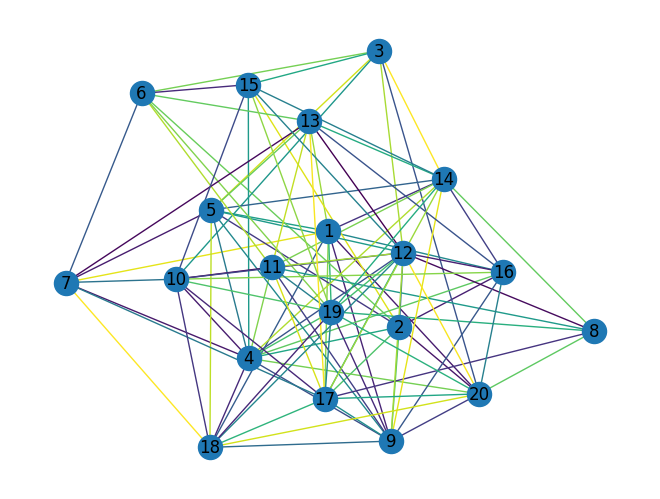

Time taken: 22.15496039390564 seconds

Running test graph_121_edges.txt...
[ 58  88  19  94  12  91  96  72  83  65  30   0 115  23  10  61  72  48
  58  89  96 116  11  81  94  63  79   1 114  81  40 109  32 108  84 103
  43  76  91  93  36 108   5  59  41   0  96  61 108  80  62 105  21  45
  28  63  69 120  22  50   5  18  65  66  42  65   3  66  98  47  59 105
 112  24  63  82  64  36   1  57 117 107  89  30  76  56  71  88  23 105
   8  97  41  50  44  69  88 101 116  91  50  39 104  96  25 103  36  79
  55 114  75  71  12  19   9  51  83  16  68  92  39]
Minimum edge coloring found.
Number of colors: 77
Number of iterations: 121


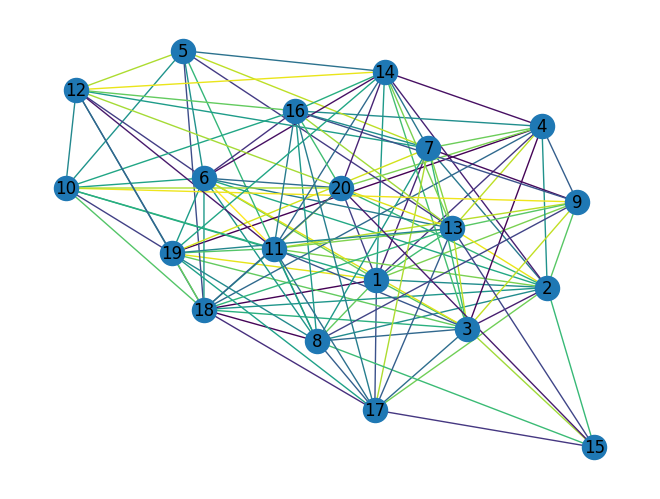

Time taken: 29.84827160835266 seconds

Running test graph_140_edges.txt...
[ 89 139  33   3  91 109  35  25  98 131  21  54  38  59 100  78  91  20
  32  81  83  59 119  17 119 100 103  33 131  49 105  96  46  41  63  51
 119 103  11 101  88 120  21  35 118  34 100  15  27  74  90 139  92 115
   8 106  61   1  44 139 105 121  68  93  83 129 136  62  66 114  99  29
  84  56  44  19  17  15  80  57  20 107  25  58  72 108  17 138  74  85
  55  59 117   4 107 109  81  89 116  41  39  73  24   8  10  67  24  18
  86  29  30  94 130 115 123  53  84  47  48  93 102  42 116  58  28  20
 104  24 122  65 132  76  39   0  85  73  74  28   8 117]
Minimum edge coloring found.
Number of colors: 95
Number of iterations: 140


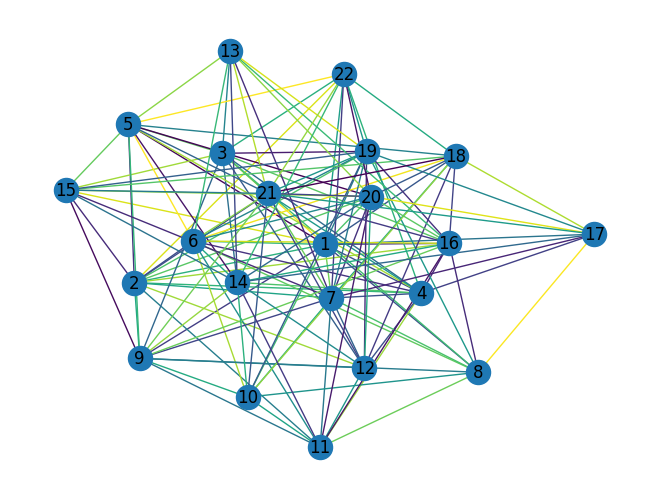

Time taken: 38.73880982398987 seconds

Running test graph_156_edges.txt...
[138 144  80  38  33  22 109 132 133  54   6  55 151  72  86 139  66  81
  54 145  50  42 120 124  94  94  73  67 143  64 145 110  70  35  18   0
  29  65 149  46 154  19  62 154  91  79 124 115 132 138 148 100  17 126
   6  28  58 143  49  99  90  13  36  43  11 151 117  73 130  11  71  43
 115 140  41  53  63  87  88  38  92  17 111 137  78  98 150  12  69  14
 125 126 133  42  16  76 120  75 131 118  22  11   5  52  36 123 128  56
  24 115  36   2 133 110   9 136  47  67 105 104  43  59  30  20 125 149
   2  90 144  23 140  81 142  58 112  40  63  35  35  88 104   9 145  14
  44 115 151  54   6 135 116  98 117  95 134   3]
Minimum edge coloring found.
Number of colors: 105
Number of iterations: 156


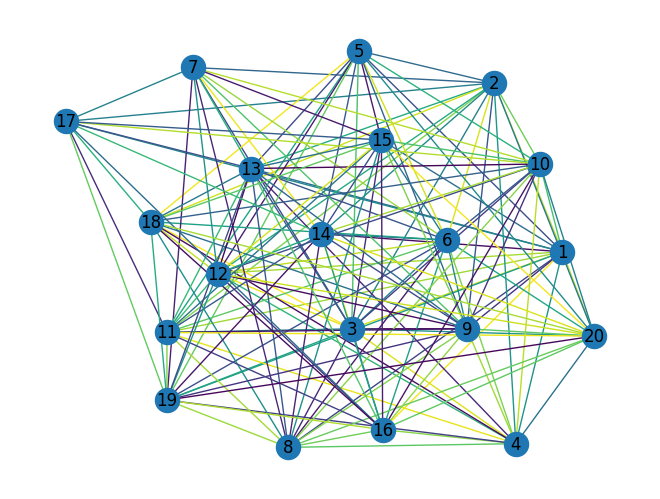

Time taken: 47.287734031677246 seconds

Running test graph_165_edges.txt...
[ 64 110 138 118   3  96 105 154 160 164  16  75 142  83  83  28  91 159
  88  39   8  44  25  11  94   6 122 150 141 145  43  39  96  80  83 116
  24  29 161 104 103  82  26 118 131  29  96  43 147  36 155  21  17  93
  48  95  87 159  47 112   7  34  90  84  75   8 164 120  61  35 133  10
  37 105  53  40  60  17 134 123 140  29 117  33 141  13   6  38  64 118
  74 152  24  37 157   5 161 132  15  61 112 139  34  92  56  60  88  89
 124 135  28  68  63 156 122  89 157   4  36 121  95 118  83 101  70  27
 109 132  46 146  76  14   4 124  81  19 128  74 118 130  30  57  61 107
 162 131   2 130  89   5  87 101 106  21 132 111  16 153 120  63  52  43
  55  97 133]
Minimum edge coloring found.
Number of colors: 111
Number of iterations: 165


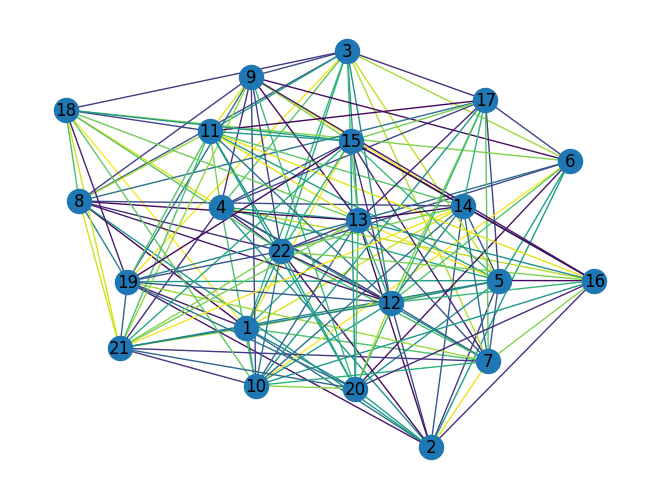

Time taken: 51.94033765792847 seconds

Running test graph_177_edges.txt...
[168 152  87  67  58  70 110 176  40  25  68 143  42  48  59 139 144  63
  75 126  11 171  69  14 136 163  23 116 113  37  54  69 173 110 154  12
 154  58 172 162 139   3 171  78  32  70  71 174  81 117  51 159 134  65
 127 165   7   8 102  50  98 154 167  37  97 105  78  21 131  17 143 144
 158  69 150 174 169  55 161 112  52  19  72  66  43 164  21 104 126  55
  18 141   0 128 142 102   9 132  42  44 115  57 171 176  37 106  95 144
  49 144 125  15 120 151 127 110  87 144 155  29  40 133 150  48  68 173
 116 157  52  66  26 128 106  15 109 123  79 171  94  33 100 128  37 146
  60 169 175 145  74   2 146 155 165 126  38  64 122 101   0  20  85  29
 152  97 117 141  62  56  86  41  40 166  58   2 109 113 124]
Minimum edge coloring found.
Number of colors: 119
Number of iterations: 177


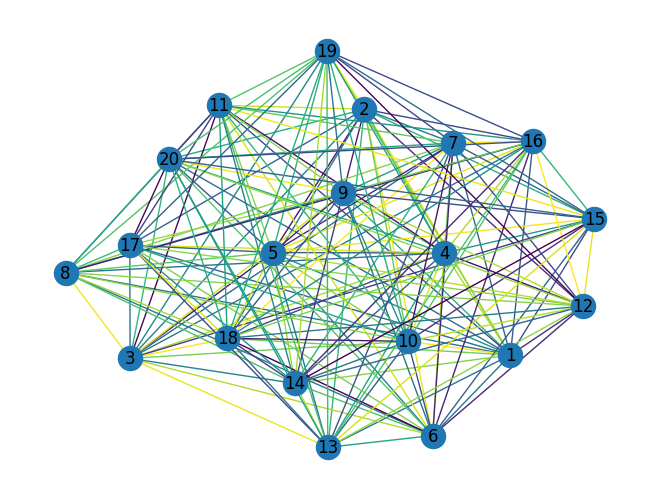

Time taken: 59.097859382629395 seconds

Running test graph_204_edges.txt...
[ 85  90  42 116 115 104 102 147 158  83  62  81  79 141 188  72 134 163
 161  27   9 110 153 103  54  81 160  15  97   1  35 148 133 140  84  55
 101 170  79 136  86 143  19 144  93 120 117  98 173  94  59 160 196  29
  96  56 113 103 133  72  64  96  92  34  55  14  30 119 102  26  28 176
 136  50 130 138  18  82 163 125  60  46 156 114  31  32  63 121  90  41
  91 165  79 125 185 121 188 154 148  98  40  86 176  64  57  64  48  94
  47 181 144  61 110  29 162 145 156 193 117  60  35 159  42  31  61 162
 123  69 142 118 141 108 116 125  78 131  14 109  76 109 118 128 135 141
 111  87 101  12  55  68 171  66  58 153  70 138 159  95 121  89 104  54
  63 160  14 159 174  63  84 164 183  88  93 163 152 121  68  14  45  74
 136  86  82  51 170 132 171  39   5 141  29  30 102  85  76 127 166  36
 128 147  73 114  79 100]
Minimum edge coloring found.
Number of colors: 129
Number of iterations: 204


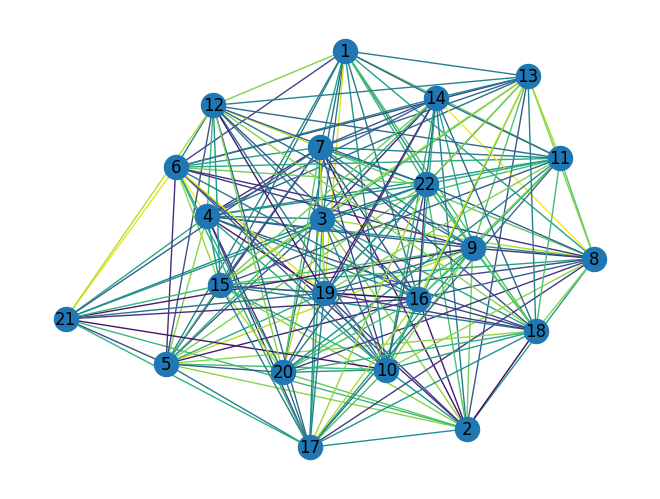

Time taken: 81.31446814537048 seconds

Running test graph_227_edges.txt...
[152  77 163  99 191 104 134 209 142 224 103 143 112 188 189 208   6 222
 146 100 165 111  36 129  20 205  86 115  79  21  12 121 218  60 127 216
 199 189  65   2 117 118 100 177   8   9 217 170  38 213 217  46  12 173
  47   4 177 130 116  69 138  56 220 159 180 108 126   2 133 172 197 173
 119 226 135 110 141  15 170  43 163 160 181  20 152 113 174 209 119 182
  31 190  45 199  95 216 181  70 120  79  50 107 112 162  52 122 120   5
  29 142  83  26 207 205 209  46 139 118  64  78 115  37  92 216 141  64
  15 180 190 103 218 176  43 110 188 177  49  44 113 175  55  24 212 184
  17 116 103 127 131  25 199 150 200 125 170  98 110 226 191 135  58   4
  72  53 119 197  96 157 215 133 179 110 173 123  54  87  24  37   0  61
 169 137  82 209 143 103  38 160 163 207  63 182  51 183 203  59 134 115
  33  28   3  59 132 200 157 194  69 189 196 155 219  90 207 206 186 117
  54  17 175  62 144 222 189  71 198  21  29]
Min

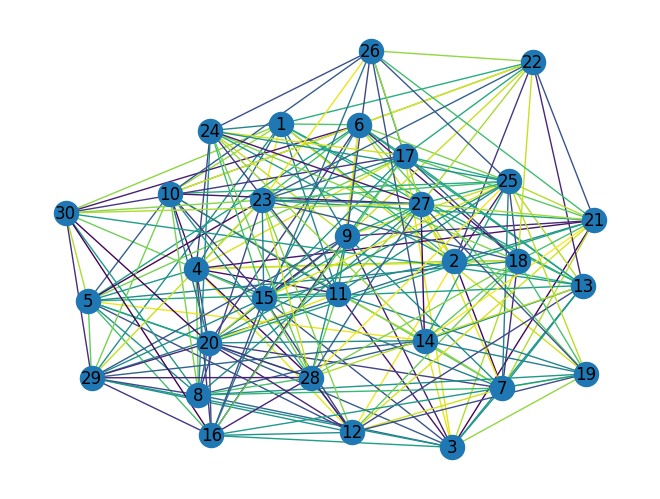

Time taken: 95.757639169693 seconds

Running test graph_273_edges.txt...
[ 43 243 179 102 260 207  29  11 248  17   9   0 269 156 211 100 229 226
 246  59 266  69 111 127 264  80  71  13 108  12   9 109 144 182 243 261
 232 103 194  89 187 246 245  94  88 119 187 255 179 222 189 254 218  85
 239 208 226 132  69  67 170 266 268  80 177 117 238  98 112 190 174 221
 228 143 192  72  46 239  58 228 219  66 227  61 183 181  45 198  82  19
  56 110 129 195 140  14   9 178 244 128  29 244 217 127 221   1 142 118
  61 259 247  15 168  92 103 196 101 232 166 110 202 140 103 126  14  18
  46 138 210  25  51 137 180  99  34 229 155 205 149 144  66  64 130 152
 212 250 187  17 247 104  13 110  59 237 231   2  22 256 187 227  77   6
 205 244 158 168  62 202 224 128 203  39 158 270 232 191 190 106 217 120
 163  73  14 203 118  55   0 254 185 123 153 156  26 126  80 174  23  43
 142 150  54 210 131 128  88  44 109  55  89 245 112  64 272 251 141  60
  27 235 165 172  68 187  47 271  67  91 215 225  4

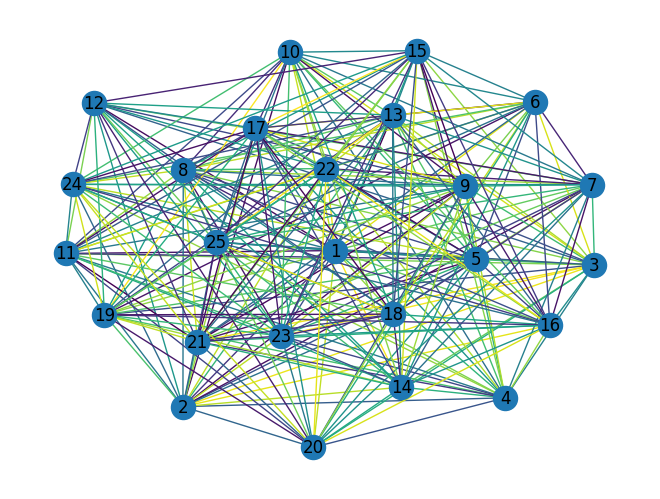

Time taken: 135.78108549118042 seconds

Running test graph_275_edges.txt...
[201 107 214  86  15 211 202 121  88 236  99  98 218  77 179 109 230  64
 173  37  69 208 196 212 116 123 160 115 103 163 169 206 246 206  35 149
 153 161 201 187  46 167  27  66 122 138 146 123 218 135 107 172 249 133
 161  82 238  99  68  53 192 143 123 219  28 206 145  53 241 115 148 230
  37  76 140  32 130  93 213  60  36 184 198 156  35 137 156 230  86 119
 197 119 149  65 241 205 216 126  97  92 166  21 104 126 112 146  98 111
 104 143 119 247 109  78  53 215 170 145  44 191 169  89 171 220  68  85
 137  66 110  96 209 237 237  98 103 101 141 128  60 175  82 110 171  53
  69 142 189 138 134  21 215  63 142  13  67 222 201 205  65  85  57  92
 124  77 224 204  80 111  85  93 166  98  59 259 177 193 160 208  65 192
 133 181 200  41 192  52 195  46 214 155 225 216 185 188 260 176 172  66
 225  98 207 169  44 236 139  90 188 213  29 213  99  41  50 132 174  31
  57 107 184 239 178 185 205  94 138 206 172  34

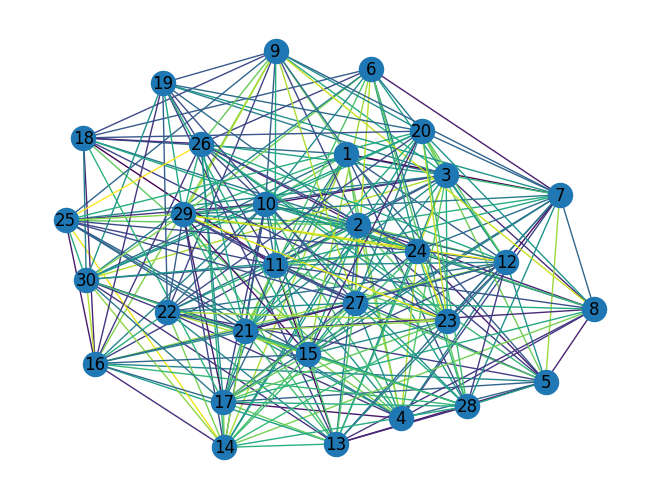

Time taken: 140.94735741615295 seconds



In [11]:
with open('./results/pso_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')